In [76]:
!pip install sklearn_pandas
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
##import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from scipy import stats
color = sns.color_palette()
from sklearn import model_selection, preprocessing
import datetime
import scipy as sp
# Get ready for lots of annoying deprecation warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn_pandas import DataFrameMapper
%matplotlib inline

  Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x0000000004643470>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/sklearn-pandas/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x0000000004643978>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/sklearn-pandas/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x0000000004643588>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/sklearn-pandas/
  Retrying (Retry(total=1, connect=None, read=None, redirect=Non

ImportError: No module named sklearn_pandas

In [1]:
def clean_data_macro(df):
    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    df.fillna(df.median(),inplace = True)
    return df

### Summary Clean for train set

In [3]:
# drop missing value >0.35 of total observations
# keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1, inplace=True)    
    return df

## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df.drop(build_feature,axis = 1)
    return df

# remove outliers
'''def reject_outliers(df, m = 1):
    d = np.abs(df - np.median(df))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return df[s<m]
'''
def reject_outliers(df, iq_range=0.5):
    #df[np.abs(df.Data-df.Data.mean())<=(3*df.Data.std())]
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = df.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return df[ (df - median).abs() <= iqr]

def clean_data(df):
    #add str feature 
    #df_all.apartment_name=df_all.sub_area + df_all['metro_km_avto'].astype(str)

    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    
    # fill build_ and cafe_, state, NA to 0

    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    #build_feature
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    #build fill median or 0?
    df[build_feature].fillna(df[build_feature].median(),inplace=True)
    #fill state
    df['state'].fillna(0,inplace=True) 
    df.fillna(df.median(), inplace = True)
    return df

In [28]:
# add month year week and other feature
def add_feature(df_all):
    month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

    week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

    df_all['month'] = df_all.timestamp.dt.month
    df_all['dow'] = df_all.timestamp.dt.dayofweek

    # Other feature engineering
    df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
    df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
    
    df_all['rel_kitch_sq'].fillna(0,inplace=True)
    df_all['rel_floor'].fillna(0,inplace=True)
    
    df_all['room_size'] = df_all['life_sq'] / df_all['num_room'].astype(float)
   # df_all.replace(np.inf, np.nan)
    ##trainBuild = df_train.dropna()
    df_all["yearbuilt"] = pd.to_numeric(df_all["build_year"].map(lambda x:str(x).split(".")[0]),errors='coerce')
    # Remove timestamp buildyear column (may overfit the model in train)
    df_all.drop(['timestamp'], axis=1, inplace=True)
    return df_all

In [38]:
#load files
train = pd.read_csv('./data/output/train_clean.csv', parse_dates=['timestamp'])
test = pd.read_csv('./data/output/test_clean.csv', parse_dates=['timestamp'])
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro = pd.read_csv('./data/input/macro.csv',parse_dates=['timestamp'],
                   usecols=['timestamp']+macro_cols)
macros = clean_data_macro(macro) #clean macros

#id_test = test.id

In [39]:
df_train = clean_data(train)
df_train.fillna(df_train.median(),inplace = True)
df_train.shape

(30396, 292)

In [41]:
df_test = clean_data(test)
df_test.fillna(df_test.median(),inplace = True)
df_test.shape

(7662, 291)

In [42]:
df_train = pd.merge_ordered(df_train, macros, on='timestamp', how='left')
df_train.shape

(30396, 305)

In [43]:
df_test = pd.merge_ordered(df_test, macros, on='timestamp', how='left')
df_test.shape

(7662, 304)

In [44]:
dtrain=add_feature(df_train)
print dtrain.shape
dtest=add_feature(df_test)
dtest.shape

(30396, 312)


(7662, 311)

In [45]:
xtrain = clean_data_macro(dtrain)
xtest=clean_data_macro(dtest)
print xtrain.shape
print xtest.shape

(30396, 312)
(7662, 311)


In [46]:
#train low correlated feature or VIF 
#train_feature = pd.read_csv("./data/output/train_feature_multicoliear.csv")
train_feature = pd.read_csv("./data/output/train_corr_drop.csv")# to drop
train_feature.shape

(30471, 142)

In [78]:
#readin train set
#df_train = pd.read_csv("./data/input/train.csv",parse_dates=['timestamp'],
                      #usecols =['timestamp','price_doc','build_year']+train_feature.columns.tolist())
#df_train = pd.read_csv("./data/input/train.csv",parse_dates=['timestamp'])
feature_drop = train_feature.columns.tolist()+["price_doc"]+["id"]
y_train =np.log1p(xtrain["price_doc"])
x_train=xtrain.drop(feature_drop, axis = 1)
x_train.shape

(30396, 168)

In [51]:
dtype_df = x_train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,77
1,float32,92


In [79]:
#feature_drop.remove("price_doc")
feature_drop = train_feature.columns.tolist()+["id"]
x_test = xtest.drop(feature_drop, axis = 1)
x_test.shape

(7662, 168)

In [80]:
#scale and center for ridge & lasso
X_scaler = StandardScaler()
x_train_feature = X_scaler.fit_transform(x_train)
x_test_feature = X_scaler.transform(x_test)

In [81]:
x_train_scale= pd.DataFrame(x_train_feature, index=x_train.index, columns=x_train.columns)
x_train_scale.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,museum_visitis_per_100_cap,apartment_build,month_year_cnt,week_year_cnt,month,dow,rel_floor,rel_kitch_sq,room_size,yearbuilt
0,-0.509124,-0.398877,-0.693639,0.0695,-0.441666,-0.005756,0.090872,-0.004263,-0.95677,-1.718994,...,-1.705883,-5.681733,-2.284752,-1.888030,0.355458,1.780819,-0.869131,0.403689,-0.560230,-0.005756
1,-0.928870,-0.893301,-0.882798,0.0695,-0.441666,-0.005756,0.090872,-0.004263,-0.95677,-0.165284,...,-1.705883,-5.681733,-2.284752,-1.878993,0.355458,-0.758310,-1.086592,1.277864,-1.020777,-0.005756
2,-0.509124,-0.275271,-1.071957,0.0695,-0.441666,-0.005756,0.090872,-0.004263,-0.95677,1.337486,...,-1.705883,-5.681733,-2.284752,-1.878993,0.355458,1.780819,-1.304054,0.403689,-0.445094,-0.005756
3,1.636249,1.022593,0.252156,0.0695,-0.441666,-0.005756,0.090872,-0.004263,-0.95677,-0.292637,...,-1.705883,-5.681733,-2.188680,-1.888030,0.639705,0.511255,0.218175,-1.303190,0.763841,-0.005756
4,1.076587,2.691274,-0.693639,0.0695,-0.441666,-0.005756,0.090872,-0.004263,-0.95677,-1.795406,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,-1.393092,-0.869131,-1.054532,2.318186,-0.005756


In [82]:
x_test_scale= pd.DataFrame(x_test_feature, index=x_test.index, columns=x_test.columns)
x_test_scale.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,museum_visitis_per_100_cap,apartment_build,month_year_cnt,week_year_cnt,month,dow,rel_floor,rel_kitch_sq,room_size,yearbuilt
0,-0.695678,-0.788236,-1.071957,-0.951830,-0.441666,-0.005609,-1.360595,0.434147,1.497405,-0.980345,...,-0.547941,-0.569462,-1.235965,-1.363919,0.071211,-0.123527,-1.062430,1.152030,0.268754,-0.005609
1,1.179191,-0.176386,0.062997,0.682298,-0.441666,-0.005713,1.542339,0.239298,-0.138711,0.649778,...,-0.547941,-0.569462,-1.235965,-1.363919,0.071211,-0.123527,-0.306290,-0.993698,-0.940181,-0.005713
2,-0.625720,-0.516303,-0.882798,-1.768894,0.335956,-0.005939,0.090872,-1.563053,0.679347,0.191306,...,-0.547941,-0.569462,-1.235965,-1.363919,0.071211,-0.123527,0.087698,-0.794975,-0.669610,-0.005939
3,0.414319,0.157350,1.765428,0.682298,-0.441666,-0.005452,0.090872,0.239298,1.497405,0.700719,...,-0.547941,-0.569462,-1.235965,-1.363919,0.071211,-0.123527,1.305481,-0.496200,-0.042115,-0.005452
4,-0.649039,0.404562,1.765428,0.682298,-0.441666,-0.005713,-1.360595,0.239298,-0.138711,0.649778,...,-0.547941,-0.569462,-1.235965,-1.363919,0.071211,-0.123527,1.305481,0.873255,2.490891,-0.005713


In [74]:
'''mapper = DataFrameMapper([(x_train.columns, StandardScaler())])
scaled_features = mapper.fit_transform(x_train.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=x_train.index, columns=x_train.columns)
scaled_features_df.head()

NameError: name 'DataFrameMapper' is not defined

In [85]:
# Remove near zero variance features

def get_low_variance_columns(dframe=None, columns=None,
                             skip_columns=None, thresh=0.0,
                             autoremove=False):
    """
    Wrapper for sklearn VarianceThreshold for use on pandas dataframes.
    """
    print("Finding low-variance features.")
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(column)
                       for column
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=thresh)

        # fit vt to data
        vt.fit(X)

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        pass

    return dframe

In [94]:
get_low_variance_columns(dframe=x_train_scale, columns=None,
                             skip_columns=None, thresh=0.1,
                             autoremove=False)

Finding low-variance features.
labels [None] not contained in axis
Could not remove low-variance features. Something went wrong.


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,museum_visitis_per_100_cap,apartment_build,month_year_cnt,week_year_cnt,month,dow,rel_floor,rel_kitch_sq,room_size,yearbuilt
0,-0.509124,-0.398877,-0.693639,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-1.718994,...,-1.705883,-5.681733,-2.284752,-1.888030,0.355458,1.780819,-0.869131,0.403689,-0.560230,-0.005756
1,-0.928870,-0.893301,-0.882798,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-0.165284,...,-1.705883,-5.681733,-2.284752,-1.878993,0.355458,-0.758310,-1.086592,1.277864,-1.020777,-0.005756
2,-0.509124,-0.275271,-1.071957,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,1.337486,...,-1.705883,-5.681733,-2.284752,-1.878993,0.355458,1.780819,-1.304054,0.403689,-0.445094,-0.005756
3,1.636249,1.022593,0.252156,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-0.292637,...,-1.705883,-5.681733,-2.188680,-1.888030,0.639705,0.511255,0.218175,-1.303190,0.763841,-0.005756
4,1.076587,2.691274,-0.693639,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-1.795406,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,-1.393092,-0.869131,-1.054532,2.318186,-0.005756
5,0.610201,0.775380,1.197951,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-0.088872,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,-0.758310,1.305481,-0.779275,0.533568,-0.005756
6,-1.348617,-1.202317,0.441315,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,1.159191,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,0.511255,0.435636,2.781446,-1.308619,-0.005756
7,-0.462485,0.651774,-0.504480,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-1.718994,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,1.146037,-0.651670,0.328633,0.418431,-0.005756
8,-0.555762,-0.398877,-0.504480,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-0.827521,...,-1.705883,-5.681733,-2.188680,-1.851884,0.639705,1.780819,-0.651670,0.482318,-0.560230,-0.005756
9,-0.835593,-0.769695,0.252156,0.069500,-0.441666,-0.005756,0.090872,-0.004263,-0.956770,-0.674697,...,-1.705883,-5.681733,-2.188680,-1.860921,0.639705,-0.758310,0.218175,1.045830,-0.905640,-0.005756


### Ridge & Lasso

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [96]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [99]:
ridge = Ridge(normalize=True)
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)
np.shape(coefs)

(100L, 168L)

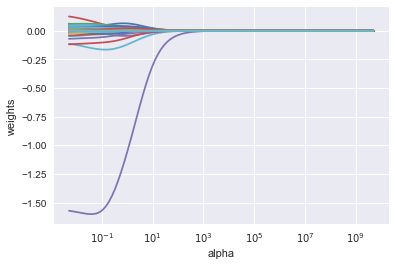

In [100]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [101]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(x_train, y_train, test_size=0.5, random_state=1)

In [103]:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(train_x, train_y)
# Fit a ridge regression on the training data
pred2 = ridge2.predict(test_x)
# Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=x_train.columns))
# Print coefficients
print(mean_squared_error(test_y, pred2))
# Calculate the test MSE

full_sq                                  2.097311e-03
life_sq                                  1.773526e-03
floor                                    2.161125e-03
max_floor                                2.301819e-03
material                                 1.558141e-03
build_year                               3.744658e-09
num_room                                 4.144876e-02
kitch_sq                                 8.879186e-03
state                                    5.059607e-03
sub_area                                -9.961028e-05
area_m                                  -1.426577e-10
indust_part                             -6.403955e-02
preschool_quota                         -1.532458e-06
children_school                          7.193152e-07
school_quota                             3.351141e-08
school_education_centers_raion           2.175458e-03
school_education_centers_top_20_raion    5.683490e-03
hospital_beds_raion                      4.958105e-06
healthcare_centers_raion    

In [104]:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(train_x, train_y)
# Fit a ridge regression on the training data
pred3 = ridge3.predict(test_x)
# Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=x_train.columns))
# Print coefficients
print(mean_squared_error(test_y, pred3))
# Calculate the test MSE

full_sq                                  1.356908e-12
life_sq                                  1.291450e-12
floor                                    1.439579e-12
max_floor                                1.258937e-12
material                                 2.313466e-12
build_year                               2.002752e-18
num_room                                 3.083828e-11
kitch_sq                                 5.030909e-12
state                                    6.896931e-12
sub_area                                -1.126994e-13
area_m                                  -4.598328e-19
indust_part                             -3.482245e-11
preschool_quota                         -8.615858e-16
children_school                          1.937438e-15
school_quota                             2.677025e-16
school_education_centers_raion           3.029825e-12
school_education_centers_top_20_raion    1.369469e-11
hospital_beds_raion                      6.915106e-15
healthcare_centers_raion    

In [105]:
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error', normalize=True)
ridgecv.fit(train_x, train_y)
ridgecv.alpha_

C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\qija\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and 

0.0050000000000000001

In [106]:
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(train_x, train_y)
mean_squared_error(test_y, ridge4.predict(test_x))

0.21134176559791593

In [107]:
cv_score_train = cross_validation.cross_val_score(ridge4, train_x, train_y)
print cv_score_train

cv_score_vl = cross_validation.cross_val_score(ridge4, test_x, test_y)
print cv_score_vl

[ -6.43219097e+03   3.88091385e-01   3.96136391e-01]
[ 0.40581095  0.38683625  0.3839062 ]


### Lasso

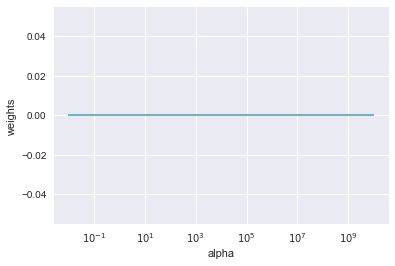

In [112]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(train_x), train_y)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [113]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(train_x, train_y)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_x, train_y)
mean_squared_error(test_y, lasso.predict(test_x))

0.2128456352139278

In [114]:
cv_score_lasso = cross_validation.cross_val_score(lasso, test_x, test_y)
print cv_score_lasso

[ 0.40029407  0.38497143  0.38008372]
